بسم الله 

** Importing liberies and frameworks **

In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

2024-02-24 11:54:45.683015: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-24 11:54:45.683147: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-24 11:54:45.851092: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


**Load videos and Preprocessing : ** defines a function load_video that takes a path to a video file as input and returns a preprocessed version of the video frames as a list of TensorFlow tensors lets eplain this with a simple graphe *

Test the function (LOad_video)

In [2]:
def load_video(path:str) -> List[float]:
    cap=cv2.VideoCapture(path)
    frames=[]
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame=tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()
    
    mean=tf.math.reduce_mean(frames)
    std=tf.math.reduce_std(tf.cast(frames,tf.float32))
    return tf.cast((frames-mean),tf.float32)/std

In [3]:
path="/kaggle/input/lipreading/data/s1/bbaf2n.mpg"
value=load_video(path)
value

<tf.Tensor: shape=(75, 46, 140, 1), dtype=float32, numpy=
array([[[[1.4991663 ],
         [1.4991663 ],
         [1.4616871 ],
         ...,
         [0.41227072],
         [0.41227072],
         [0.41227072]],

        [[1.4991663 ],
         [1.4991663 ],
         [1.4616871 ],
         ...,
         [0.41227072],
         [0.41227072],
         [0.41227072]],

        [[1.4616871 ],
         [1.4616871 ],
         [1.4991663 ],
         ...,
         [0.3373124 ],
         [0.3373124 ],
         [0.3373124 ]],

        ...,

        [[1.0494163 ],
         [1.0494163 ],
         [1.0119373 ],
         ...,
         [0.11243746],
         [0.11243746],
         [0.07495831]],

        [[1.0494163 ],
         [1.0494163 ],
         [1.0119373 ],
         ...,
         [0.11243746],
         [0.07495831],
         [0.07495831]],

        [[1.0494163 ],
         [1.0494163 ],
         [1.0119373 ],
         ...,
         [0.07495831],
         [0.07495831],
         [0.03747915]]],


  

**Extracts information from files, and compiles a vocabulary list**

In [4]:
#ADDITIONAL FUNCTION I MADE TO GET vocab WHICH IS A PARAMETER FOR THE CHAR_TO_NUM FUNCTION
def get_vocab():
    vocab=[]
    directory="/kaggle/input/lipreading/data/alignments/s1"
    for file in os.listdir(directory):
        file_path = os.path.join(directory, file)
        with open(file_path, 'r') as f:
            lines=f.readlines()
            for line in lines:
                line=line.split()
                vocab.append(line[2])
    return vocab       

In [5]:
vocab=np.unique(get_vocab())

In [6]:
print(vocab)

['a' 'again' 'at' 'b' 'bin' 'blue' 'by' 'c' 'd' 'e' 'eight' 'f' 'five'
 'four' 'g' 'green' 'h' 'i' 'in' 'j' 'k' 'l' 'lay' 'm' 'n' 'nine' 'now'
 'o' 'one' 'p' 'place' 'please' 'q' 'r' 'red' 's' 'set' 'seven' 'sil'
 'six' 'soon' 'sp' 't' 'three' 'two' 'u' 'v' 'white' 'with' 'x' 'y' 'z'
 'zero']


> Create a Mapping layers for preprocessing using tensorflow Stringlookup :tf.keras.layers.StringLookup

In [7]:
char_to_num= tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char=tf.keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), oov_token="",invert=True)

> char_to_num StringLookup Layer:
> 
> tf.keras.layers.StringLookup is used to create a layer that maps characters to numerical indices.
> The vocabulary parameter is set to your vocab, which is the list of characters obtained from your get_vocab function.
> oov_token stands for "out-of-vocabulary" token and is set to an empty string (""). This token is used for unseen characters during inference.
> num_to_char StringLookup Layer:
> 
> Another StringLookup layer is created to map numerical indices back to characters.
> The vocabulary parameter is set to the vocabulary obtained from the char_to_num layer using char_to_num.get_vocabulary().
> oov_token is also set to an empty string (""), and invert is set to True, indicating that this layer should perform an inverse mapping.

> *After convert the alignments to a num (Conversion to Numerical Indices) ---> reshape the tensor to one dim tensor*

In [8]:
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines=f.readlines()
        
            
        
    tokens=[]
    for line in lines:
        line=line.split()
        if line[2]!= 'sil':
            tokens= [*tokens,' ',line[2]]
        
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens,input_encoding='UTF-8'),(-1)))[1:]

In [9]:
path="/kaggle/input/lipreading/data/alignments/s1/bbaf2n.align"
load_alignments(path)


<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 4, 18, 25,  0,  4, 22, 46, 10,  0,  1, 43,  0, 12,  0, 43,  0, 28,
        0, 25, 28,  0])>

In [10]:
def load_data(path:str):
    path=bytes.decode(path.numpy())
    file_name=path.split('/')[-1].split('.')[0]
    video_path=os.path.join('/kaggle/input/lipreading/data','s1',f'{file_name}.mpg')
    alignment_path=os.path.join('/kaggle/input/lipreading/data','alignments','s1',f'{file_name}.align')
    frames=load_video(video_path)
    alignments=load_alignments(alignment_path)
    
    return frames,alignments

In [11]:
#TESTING THE OUTPUT FOR A SAMPLE FILE
path="/kaggle/input/lipreading/data/s1/bbaf2n.mpg"
frames, alignments=load_data(tf.convert_to_tensor(path))
print("frames:",frames)
print("alignments:",alignments)

frames: tf.Tensor(
[[[[1.4991663 ]
   [1.4991663 ]
   [1.4616871 ]
   ...
   [0.41227072]
   [0.41227072]
   [0.41227072]]

  [[1.4991663 ]
   [1.4991663 ]
   [1.4616871 ]
   ...
   [0.41227072]
   [0.41227072]
   [0.41227072]]

  [[1.4616871 ]
   [1.4616871 ]
   [1.4991663 ]
   ...
   [0.3373124 ]
   [0.3373124 ]
   [0.3373124 ]]

  ...

  [[1.0494163 ]
   [1.0494163 ]
   [1.0119373 ]
   ...
   [0.11243746]
   [0.11243746]
   [0.07495831]]

  [[1.0494163 ]
   [1.0494163 ]
   [1.0119373 ]
   ...
   [0.11243746]
   [0.07495831]
   [0.07495831]]

  [[1.0494163 ]
   [1.0494163 ]
   [1.0119373 ]
   ...
   [0.07495831]
   [0.07495831]
   [0.03747915]]]


 [[[1.4242079 ]
   [1.4242079 ]
   [1.4242079 ]
   ...
   [0.3373124 ]
   [0.3373124 ]
   [0.3373124 ]]

  [[1.4242079 ]
   [1.4242079 ]
   [1.4242079 ]
   ...
   [0.3373124 ]
   [0.3373124 ]
   [0.3373124 ]]

  [[1.4242079 ]
   [1.4242079 ]
   [1.4242079 ]
   ...
   [0.29983324]
   [0.29983324]
   [0.29983324]]

  ...

  [[1.0494163 ]
   [

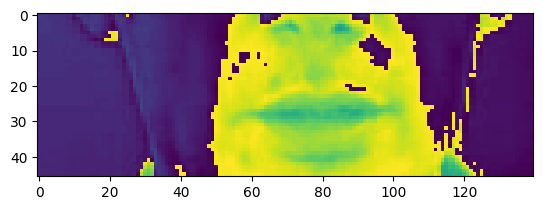

In [12]:
plt.imshow(frames[15])

**
Sets up a TensorFlow data pipeline for loading lipreading data from video file**

In [13]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

In [14]:
data = tf.data.Dataset.list_files('/kaggle/input/lipreading/data/s1/*.mpg')
data = data.shuffle(500,reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# # ADDED DOR SPLIT
train = data.take(450)
test = data.skip(450)

In [15]:
frames, alighnments = data.as_numpy_iterator().next()

In [16]:
sample = data.as_numpy_iterator()

In [17]:
val = sample.next();val[0]

array([[[[[1.4972    ],
          [1.4588102 ],
          [1.1516923 ],
          ...,
          [0.34550768],
          [0.30711794],
          [0.30711794]],

         [[1.4972    ],
          [1.4588102 ],
          [0.9597436 ],
          ...,
          [0.34550768],
          [0.30711794],
          [0.30711794]],

         [[1.4972    ],
          [1.4972    ],
          [1.3820307 ],
          ...,
          [0.34550768],
          [0.30711794],
          [0.30711794]],

         ...,

         [[1.1516923 ],
          [1.0749128 ],
          [1.0749128 ],
          ...,
          [0.        ],
          [0.        ],
          [0.        ]],

         [[1.0749128 ],
          [1.0749128 ],
          [1.0749128 ],
          ...,
          [9.789385  ],
          [9.789385  ],
          [9.789385  ]],

         [[1.0749128 ],
          [1.0749128 ],
          [1.0749128 ],
          ...,
          [9.789385  ],
          [9.789385  ],
          [9.789385  ]]],


        [[[1.4588

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D,Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [19]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, Activation, MaxPool3D, TimeDistributed, Flatten, Bidirectional, LSTM, Dropout, Dense, BatchNormalization

model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75, 46, 140, 1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(char_to_num.vocabulary_size() + 1, kernel_initializer='he_normal', activation='softmax'))


In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128   3584      
                             )                                   
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128   0         
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 75, 23, 70, 128)   0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                        

In [22]:
yhat = model.predict(val[0])

1/1 [==============================] - 6s 6s/step


In [23]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [24]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [25]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [26]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True) 
schedule_callback = LearningRateScheduler(scheduler)
example_callback = ProduceExample(test)

In [27]:
history = model.fit(train, validation_data=test, epochs=50, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/50


I0000 00:00:1708775731.671152      72 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


145/450 [========>.....................] - ETA: 4:44 - loss: 192.0644

[mpeg1video @ 0x7f4858042000] ac-tex damaged at 22 17
[mpeg1video @ 0x7f4858042000] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 144.2360

[mpeg1video @ 0x7f485805c140] ac-tex damaged at 22 17
[mpeg1video @ 0x7f485805c140] Warning MVs not available
[mpeg1video @ 0x7f44118525c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7f44118525c0] Warning MVs not available


1/1 [==============================] - 2s 2s/step
Original: setblueithhsixno
Prediction: lsaeeenn
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: placeredithxsixno
Prediction: lsaeennn
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 884s 2s/step - loss: 144.2360 - val_loss: 97.8175 - lr: 1.0000e-04
Epoch 2/50
123/450 [=======>......................] - ETA: 5:01 - loss: 108.1066

[mpeg1video @ 0x7f48400bf5c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7f48400bf5c0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 103.9832

[mpeg1video @ 0x7f4954013740] ac-tex damaged at 22 17
[mpeg1video @ 0x7f4954013740] Warning MVs not available


1/1 [==============================] - 0s 196ms/step
Original: placehiteithqeightno
Prediction: saeii
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: placegreenithesevensoon
Prediction: piaeiiii
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 645s 1s/step - loss: 103.9832 - val_loss: 90.8811 - lr: 1.0000e-04
Epoch 3/50
 16/450 [>.............................] - ETA: 6:37 - loss: 95.9181

[mpeg1video @ 0x7f48180d3080] ac-tex damaged at 22 17
[mpeg1video @ 0x7f48180d3080] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 95.5452

[mpeg1video @ 0x7f48680955c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7f48680955c0] Warning MVs not available


1/1 [==============================] - 0s 188ms/step
Original: placebluebyveightplease
Prediction: siaennn
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: setredinaeightplease
Prediction: siaen
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 644s 1s/step - loss: 95.5452 - val_loss: 89.9187 - lr: 1.0000e-04
Epoch 4/50
389/450 [========================>.....] - ETA: 55s - loss: 91.0897

[mpeg1video @ 0x7f447802e840] ac-tex damaged at 22 17
[mpeg1video @ 0x7f447802e840] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 91.0829

[mpeg1video @ 0x7f483011d940] ac-tex damaged at 22 17
[mpeg1video @ 0x7f483011d940] Warning MVs not available


1/1 [==============================] - 0s 192ms/step
Original: setredithvthreeagain
Prediction: biaeeeeeiene
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: layhiteinloneagain
Prediction: biaeeieieieieaeae
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 642s 1s/step - loss: 91.0829 - val_loss: 93.6714 - lr: 1.0000e-04
Epoch 5/50
338/450 [=====================>........] - ETA: 1:42 - loss: 87.8326

[mpeg1video @ 0x7f4988081580] ac-tex damaged at 22 17
[mpeg1video @ 0x7f4988081580] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 87.8111

[mpeg1video @ 0x7f481e5f9f80] ac-tex damaged at 22 17
[mpeg1video @ 0x7f481e5f9f80] Warning MVs not available


1/1 [==============================] - 0s 195ms/step
Original: placegreeninjninesoon
Prediction: blne
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: layredithzsptono
Prediction: blne
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 643s 1s/step - loss: 87.8111 - val_loss: 102.9268 - lr: 1.0000e-04
Epoch 6/50
166/450 [==========>...................] - ETA: 4:19 - loss: 85.1253

[mpeg1video @ 0x7f48b4086f40] ac-tex damaged at 22 17
[mpeg1video @ 0x7f48b4086f40] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 84.3948

[mpeg1video @ 0x7f44780514c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7f44780514c0] Warning MVs not available


1/1 [==============================] - 0s 195ms/step
Original: binblueinzzerono
Prediction: plaeeiieeaen
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: placehiteinjfourplease
Prediction: plaeeieiieeaen
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 640s 1s/step - loss: 84.3948 - val_loss: 83.6611 - lr: 1.0000e-04
Epoch 7/50
204/450 [============>.................] - ETA: 3:43 - loss: 80.2767

[mpeg1video @ 0x7f4858075f80] ac-tex damaged at 22 17
[mpeg1video @ 0x7f4858075f80] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 77.3060

[mpeg1video @ 0x7f49800a8600] ac-tex damaged at 22 17
[mpeg1video @ 0x7f49800a8600] Warning MVs not available


1/1 [==============================] - 0s 187ms/step
Original: bingreeninnzerono
Prediction: slae
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: sethiteinbfourplease
Prediction: slae
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 639s 1s/step - loss: 77.3060 - val_loss: 75.3185 - lr: 1.0000e-04
Epoch 8/50
174/450 [==========>...................] - ETA: 4:11 - loss: 71.6731

[mpeg1video @ 0x7f482c0a7b00] ac-tex damaged at 22 17
[mpeg1video @ 0x7f482c0a7b00] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 70.2395

[mpeg1video @ 0x7f48b406e540] ac-tex damaged at 22 17
[mpeg1video @ 0x7f48b406e540] Warning MVs not available


1/1 [==============================] - 0s 184ms/step
Original: placegreeninjeightno
Prediction: slaeye
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: setredbyusevensoon
Prediction: slaeyee
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 637s 1s/step - loss: 70.2395 - val_loss: 60.1989 - lr: 1.0000e-04
Epoch 9/50
 58/450 [==>...........................] - ETA: 5:55 - loss: 66.6757

[mpeg1video @ 0x7f48080ba080] ac-tex damaged at 22 17
[mpeg1video @ 0x7f48080ba080] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 64.6321

[mpeg1video @ 0x7f485402a040] ac-tex damaged at 22 17
[mpeg1video @ 0x7f485402a040] Warning MVs not available


1/1 [==============================] - 0s 185ms/step
Original: setgreenatieightplease
Prediction: slaetreteen
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: placehitebykonesoon
Prediction: plaetreteo
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 635s 1s/step - loss: 64.6321 - val_loss: 56.4846 - lr: 1.0000e-04
Epoch 10/50
141/450 [========>.....................] - ETA: 4:40 - loss: 63.1395

[mpeg1video @ 0x7f499007a680] ac-tex damaged at 22 17
[mpeg1video @ 0x7f499007a680] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 62.2460

[mpeg1video @ 0x7f48184200c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7f48184200c0] Warning MVs not available


1/1 [==============================] - 0s 202ms/step
Original: placeredatjthreeagain
Prediction: plaeyreieeaea
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: setgreenbyceightplease
Prediction: plaeyreieea
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 635s 1s/step - loss: 62.2460 - val_loss: 54.2495 - lr: 1.0000e-04
Epoch 11/50
166/450 [==========>...................] - ETA: 4:16 - loss: 60.1752

[mpeg1video @ 0x7f48b4072800] ac-tex damaged at 22 17
[mpeg1video @ 0x7f48b4072800] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 59.6745

[mpeg1video @ 0x7f448004ae40] ac-tex damaged at 22 17
[mpeg1video @ 0x7f448004ae40] Warning MVs not available


1/1 [==============================] - 0s 185ms/step
Original: layhitebyzfourno
Prediction: laeybeie
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: laybluebyqeightno
Prediction: slaenree
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 632s 1s/step - loss: 59.6745 - val_loss: 56.5066 - lr: 1.0000e-04
Epoch 12/50
 52/450 [==>...........................] - ETA: 6:00 - loss: 58.8147

[mpeg1video @ 0x7f4860091bc0] ac-tex damaged at 22 17
[mpeg1video @ 0x7f4860091bc0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 57.4883

[mpeg1video @ 0x7f49900dce00] ac-tex damaged at 22 17
[mpeg1video @ 0x7f49900dce00] Warning MVs not available


1/1 [==============================] - 0s 182ms/step
Original: placegreeninqfourplease
Prediction: blaetreieeae
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: sethitebyifourno
Prediction: blaeretioo
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 633s 1s/step - loss: 57.4883 - val_loss: 51.9407 - lr: 1.0000e-04
Epoch 13/50
 13/450 [..............................] - ETA: 6:33 - loss: 53.1858

[mpeg1video @ 0x7f482c053700] ac-tex damaged at 22 17
[mpeg1video @ 0x7f482c053700] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 54.6414

[mpeg1video @ 0x7f48a4006180] ac-tex damaged at 22 17
[mpeg1video @ 0x7f48a4006180] Warning MVs not available


1/1 [==============================] - 0s 188ms/step
Original: placegreenindsixplease
Prediction: laitretnnn
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: setredinhthreeagain
Prediction: blaitrenneean
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 634s 1s/step - loss: 54.6414 - val_loss: 49.2960 - lr: 1.0000e-04
Epoch 14/50
243/450 [===============>..............] - ETA: 3:08 - loss: 52.0993

[mpeg1video @ 0x7f440c01b300] ac-tex damaged at 22 17
[mpeg1video @ 0x7f440c01b300] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 51.9980

[mpeg1video @ 0x7f485809d8c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7f485809d8c0] Warning MVs not available


1/1 [==============================] - 0s 183ms/step
Original: placeredinvfivesoon
Prediction: bsaetreteo
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: setblueatasevenagain
Prediction: laiyreieasi
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 635s 1s/step - loss: 51.9980 - val_loss: 49.0297 - lr: 1.0000e-04
Epoch 15/50
186/450 [===========>..................] - ETA: 3:59 - loss: 50.2032

[mpeg1video @ 0x7f4480083dc0] ac-tex damaged at 22 17
[mpeg1video @ 0x7f4480083dc0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 49.7841

[mpeg1video @ 0x7f4830056080] ac-tex damaged at 22 17
[mpeg1video @ 0x7f4830056080] Warning MVs not available


1/1 [==============================] - 0s 188ms/step
Original: sethiteinhnineagain
Prediction: bsinreitiean
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: setblueatteightplease
Prediction: bsinretteean
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 636s 1s/step - loss: 49.7841 - val_loss: 45.1762 - lr: 1.0000e-04
Epoch 16/50
209/450 [============>.................] - ETA: 3:37 - loss: 47.4019

[mpeg1video @ 0x7f497c0427c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7f497c0427c0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 47.0293

[mpeg1video @ 0x7f4814016e00] ac-tex damaged at 22 17
[mpeg1video @ 0x7f4814016e00] Warning MVs not available


1/1 [==============================] - 0s 184ms/step
Original: sethiteithcsevenagain
Prediction: binhieboeea
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: placehitebydsevensoon
Prediction: binleiseo
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 633s 1s/step - loss: 47.0293 - val_loss: 45.6693 - lr: 1.0000e-04
Epoch 17/50
250/450 [===============>..............] - ETA: 3:00 - loss: 44.8284

[mpeg1video @ 0x7f48600b4f80] ac-tex damaged at 22 17
[mpeg1video @ 0x7f48600b4f80] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 44.4547

[mpeg1video @ 0x5c1bc3d15180] ac-tex damaged at 22 17
[mpeg1video @ 0x5c1bc3d15180] Warning MVs not available


1/1 [==============================] - 0s 183ms/step
Original: binblueineninesoon
Prediction: binlieinon
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: placehiteinpsixno
Prediction: laiyhieiiinon
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 629s 1s/step - loss: 44.4547 - val_loss: 39.5008 - lr: 1.0000e-04
Epoch 18/50
125/450 [=======>......................] - ETA: 4:55 - loss: 40.9818

[mpeg1video @ 0x7f48380b43c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7f48380b43c0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 41.3580

[mpeg1video @ 0x7f497401de00] ac-tex damaged at 22 17
[mpeg1video @ 0x7f497401de00] Warning MVs not available


1/1 [==============================] - 0s 190ms/step
Original: placeredbypeightno
Prediction: slaereasin
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: binblueatleightplease
Prediction: binreiheease
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 634s 1s/step - loss: 41.3580 - val_loss: 38.8840 - lr: 1.0000e-04
Epoch 19/50
184/450 [===========>..................] - ETA: 3:59 - loss: 38.5090

[mpeg1video @ 0x7f482c053040] ac-tex damaged at 22 17
[mpeg1video @ 0x7f482c053040] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 38.6233

[mpeg1video @ 0x7f48640948c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7f48640948c0] Warning MVs not available


1/1 [==============================] - 0s 183ms/step
Original: bingreenatuoneagain
Prediction: bieretoeag
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: laygreeninsoneagain
Prediction: layretoeas
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 633s 1s/step - loss: 38.6233 - val_loss: 32.6731 - lr: 1.0000e-04
Epoch 20/50
192/450 [===========>..................] - ETA: 3:52 - loss: 36.0950

[mpeg1video @ 0x7f4814099880] ac-tex damaged at 22 17
[mpeg1video @ 0x7f4814099880] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 35.6358

[mpeg1video @ 0x7f484c0a45c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7f484c0a45c0] Warning MVs not available


1/1 [==============================] - 0s 185ms/step
Original: binredinmoneagain
Prediction: binrteinieain
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: binbluebyfsixno
Prediction: binbluebio
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 632s 1s/step - loss: 35.6358 - val_loss: 28.7485 - lr: 1.0000e-04
Epoch 21/50
320/450 [====================>.........] - ETA: 1:57 - loss: 32.7071

[mpeg1video @ 0x7f499007b3c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7f499007b3c0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 32.6630

[mpeg1video @ 0x7f48188fcb00] ac-tex damaged at 22 17
[mpeg1video @ 0x7f48188fcb00] Warning MVs not available


1/1 [==============================] - 0s 182ms/step
Original: layblueinxfivesoon
Prediction: laygieino
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: placegreenatytoplease
Prediction: placereitopease
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 633s 1s/step - loss: 32.6630 - val_loss: 30.4668 - lr: 1.0000e-04
Epoch 22/50
303/450 [===================>..........] - ETA: 2:12 - loss: 30.3280

[mpeg1video @ 0x7f49780247c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7f49780247c0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 30.2810

[mpeg1video @ 0x7f4478032dc0] ac-tex damaged at 22 17
[mpeg1video @ 0x7f4478032dc0] Warning MVs not available


1/1 [==============================] - 0s 190ms/step
Original: binhiteithnnineagain
Prediction: binrieyneao
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: setredatutono
Prediction: setrebttoo
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 631s 1s/step - loss: 30.2810 - val_loss: 25.8446 - lr: 1.0000e-04
Epoch 23/50
381/450 [========================>.....] - ETA: 1:01 - loss: 28.3940

[mpeg1video @ 0x7f48640948c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7f48640948c0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 28.3438

[mpeg1video @ 0x7f4980030f40] ac-tex damaged at 22 17
[mpeg1video @ 0x7f4980030f40] Warning MVs not available


1/1 [==============================] - 0s 182ms/step
Original: setgreenatisixno
Prediction: setgrteatixo
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: setgreenatponesoon
Prediction: setgrenitthrson
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 627s 1s/step - loss: 28.3438 - val_loss: 22.3645 - lr: 1.0000e-04
Epoch 24/50
188/450 [===========>..................] - ETA: 3:54 - loss: 25.6418

[mpeg1video @ 0x7f48200221c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7f48200221c0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 25.6743

[mpeg1video @ 0x7f495409eb40] ac-tex damaged at 22 17
[mpeg1video @ 0x7f495409eb40] Warning MVs not available


1/1 [==============================] - 0s 179ms/step
Original: placehitebykthreeagain
Prediction: lacehitedbyyhreain
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: layblueatdnineagain
Prediction: layblueitnegain
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 633s 1s/step - loss: 25.6743 - val_loss: 19.4610 - lr: 1.0000e-04
Epoch 25/50
450/450 [==============================] - ETA: 0s - loss: 23.4782

[mpeg1video @ 0x7f485402bc40] ac-tex damaged at 22 17
[mpeg1video @ 0x7f485402bc40] Warning MVs not available


1/1 [==============================] - 0s 183ms/step
Original: sethitebyvfiveagain
Prediction: sethitebyyfiveagain
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: placegreenithesixno
Prediction: layrenitix
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 635s 1s/step - loss: 23.4782 - val_loss: 17.7957 - lr: 1.0000e-04
Epoch 26/50
240/450 [===============>..............] - ETA: 3:08 - loss: 21.1062

[mpeg1video @ 0x5c1bc381e600] ac-tex damaged at 22 17
[mpeg1video @ 0x5c1bc381e600] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 21.4313

[mpeg1video @ 0x7f482c00adc0] ac-tex damaged at 22 17
[mpeg1video @ 0x7f482c00adc0] Warning MVs not available


1/1 [==============================] - 0s 183ms/step
Original: binblueatsonesoon
Prediction: binblueitseson
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: layhitespbyfthreesoon
Prediction: layhitebythreson
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 631s 1s/step - loss: 21.4313 - val_loss: 15.5255 - lr: 1.0000e-04
Epoch 27/50
450/450 [==============================] - ETA: 0s - loss: 19.3673

[mpeg1video @ 0x7f4808022140] ac-tex damaged at 22 17
[mpeg1video @ 0x7f4808022140] Warning MVs not available


1/1 [==============================] - 0s 186ms/step
Original: placeredbyxfiveagain
Prediction: placegredbyyfiheagain
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: laygreeninfthreeagain
Prediction: laygreninkhreain
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 629s 1s/step - loss: 19.3673 - val_loss: 14.7509 - lr: 1.0000e-04
Epoch 28/50
 37/450 [=>............................] - ETA: 6:09 - loss: 18.1799

[mpeg1video @ 0x7f48640211c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7f48640211c0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 18.0132

[mpeg1video @ 0x7f498808ff00] ac-tex damaged at 22 17
[mpeg1video @ 0x7f498808ff00] Warning MVs not available


1/1 [==============================] - 0s 190ms/step
Original: placeblueinueightno
Prediction: placeblueinnihtnon
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: laygreenatfsixplease
Prediction: laygrenayysixplese
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 629s 1s/step - loss: 18.0132 - val_loss: 12.3832 - lr: 1.0000e-04
Epoch 29/50
 92/450 [=====>........................] - ETA: 5:22 - loss: 16.4598

[mpeg1video @ 0x7f4838022640] ac-tex damaged at 22 17
[mpeg1video @ 0x7f4838022640] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 16.2453

[mpeg1video @ 0x7f497403d840] ac-tex damaged at 22 17
[mpeg1video @ 0x7f497403d840] Warning MVs not available


1/1 [==============================] - 0s 182ms/step
Original: placeblueithjtono
Prediction: placeblueithtono
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: binblueatsthreeagain
Prediction: binblueatthreain
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 633s 1s/step - loss: 16.2453 - val_loss: 12.0435 - lr: 1.0000e-04
Epoch 30/50
401/450 [=========================>....] - ETA: 44s - loss: 14.4610

[mpeg1video @ 0x7f48181a5940] ac-tex damaged at 22 17
[mpeg1video @ 0x7f48181a5940] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 14.4942

[mpeg1video @ 0x7f4858036b80] ac-tex damaged at 22 17
[mpeg1video @ 0x7f4858036b80] Warning MVs not available


1/1 [==============================] - 0s 187ms/step
Original: placegreenbyefiveagain
Prediction: placegrenbyvviveagain
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: layhiteinrthreesoon
Prediction: layhiteinrthreson
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 635s 1s/step - loss: 14.4942 - val_loss: 9.7951 - lr: 1.0000e-04
Epoch 31/50
 82/450 [====>.........................] - ETA: 5:30 - loss: 13.3573

[mpeg1video @ 0x7f4480041b00] ac-tex damaged at 22 17
[mpeg1video @ 0x7f4480041b00] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 13.1552

[mpeg1video @ 0x7f485807f8c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7f485807f8c0] Warning MVs not available


1/1 [==============================] - 0s 182ms/step
Original: binblueithtoneagain
Prediction: binblueithtonagain
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: layhiteatfoneagain
Prediction: layhiteatfoneagain
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 632s 1s/step - loss: 13.1552 - val_loss: 7.6945 - lr: 9.0484e-05
Epoch 32/50
348/450 [======================>.......] - ETA: 1:31 - loss: 11.5301

[mpeg1video @ 0x7f44780c5800] ac-tex damaged at 22 17
[mpeg1video @ 0x7f44780c5800] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 11.5253

[mpeg1video @ 0x7f44115ccc40] ac-tex damaged at 22 17
[mpeg1video @ 0x7f44115ccc40] Warning MVs not available


1/1 [==============================] - 0s 182ms/step
Original: placeblueithpeightplease
Prediction: placeblueithpeightplease
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: placeblueithpsixno
Prediction: placeblueithpsixno
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 631s 1s/step - loss: 11.5253 - val_loss: 7.4483 - lr: 8.1873e-05
Epoch 33/50
209/450 [============>.................] - ETA: 3:36 - loss: 10.4807

[mpeg1video @ 0x7f49780a4b40] ac-tex damaged at 22 17
[mpeg1video @ 0x7f49780a4b40] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 10.3668

[mpeg1video @ 0x7f4808065c40] ac-tex damaged at 22 17
[mpeg1video @ 0x7f4808065c40] Warning MVs not available


1/1 [==============================] - 0s 180ms/step
Original: binredatsnineagain
Prediction: binredatsnagain
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: layredatyfivesoon
Prediction: layredayyfiveson
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 630s 1s/step - loss: 10.3668 - val_loss: 5.7673 - lr: 7.4082e-05
Epoch 34/50
414/450 [==========================>...] - ETA: 32s - loss: 9.1988

[mpeg1video @ 0x7f486808b140] ac-tex damaged at 22 17
[mpeg1video @ 0x7f486808b140] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 9.2376

[mpeg1video @ 0x7f49880eb440] ac-tex damaged at 22 17
[mpeg1video @ 0x7f49880eb440] Warning MVs not available


1/1 [==============================] - 0s 196ms/step
Original: sethiteithpthreesoon
Prediction: sethiteithhthreson
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bingreeninnonesoon
Prediction: bingreninnoeon
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 629s 1s/step - loss: 9.2376 - val_loss: 5.3606 - lr: 6.7032e-05
Epoch 35/50
346/450 [======================>.......] - ETA: 1:33 - loss: 8.2807

[mpeg1video @ 0x7f48280ac400] ac-tex damaged at 22 17
[mpeg1video @ 0x7f48280ac400] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 8.2484

[mpeg1video @ 0x7f4974064f80] ac-tex damaged at 22 17
[mpeg1video @ 0x7f4974064f80] Warning MVs not available


1/1 [==============================] - 0s 185ms/step
Original: setgreenithjfivesoon
Prediction: setgrenithjfiveson
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: binhitebyasevenagain
Prediction: binhitebaseveagain
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 632s 1s/step - loss: 8.2484 - val_loss: 4.3242 - lr: 6.0653e-05
Epoch 36/50
400/450 [=========================>....] - ETA: 45s - loss: 7.4950

[mpeg1video @ 0x7f44114d1dc0] ac-tex damaged at 22 17
[mpeg1video @ 0x7f44114d1dc0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 7.4468

[mpeg1video @ 0x7f4860080980] ac-tex damaged at 22 17
[mpeg1video @ 0x7f4860080980] Warning MVs not available


1/1 [==============================] - 0s 181ms/step
Original: layhiteithmthreeagain
Prediction: layhiteithmthreagain
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: sethiteatvoneagain
Prediction: sethiteatvneain
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 636s 1s/step - loss: 7.4468 - val_loss: 3.8261 - lr: 5.4881e-05
Epoch 37/50
136/450 [========>.....................] - ETA: 4:43 - loss: 6.6329

[mpeg1video @ 0x7f480c096440] ac-tex damaged at 22 17
[mpeg1video @ 0x7f480c096440] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 6.7886

[mpeg1video @ 0x7f48401cd700] ac-tex damaged at 22 17
[mpeg1video @ 0x7f48401cd700] Warning MVs not available


1/1 [==============================] - 0s 181ms/step
Original: layblueinqthreeagain
Prediction: layblueinnqthreagain
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: setredbyueightplease
Prediction: setredbyueightplease
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 632s 1s/step - loss: 6.7886 - val_loss: 3.1729 - lr: 4.9659e-05
Epoch 38/50
401/450 [=========================>....] - ETA: 44s - loss: 6.4141

[mpeg1video @ 0x7f497c074080] ac-tex damaged at 22 17
[mpeg1video @ 0x7f497c074080] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 6.3814

[mpeg1video @ 0x7f481e4d0680] ac-tex damaged at 22 17
[mpeg1video @ 0x7f481e4d0680] Warning MVs not available


1/1 [==============================] - 0s 186ms/step
Original: placeredatpfourno
Prediction: placeredatpfourno
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: setredbybfivesoon
Prediction: setredbybfiveson
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 633s 1s/step - loss: 6.3814 - val_loss: 2.5818 - lr: 4.4933e-05
Epoch 39/50
391/450 [=========================>....] - ETA: 53s - loss: 5.6886

[mpeg1video @ 0x7f486806e4c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7f486806e4c0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 5.6376

[mpeg1video @ 0x5c1bc45c6840] ac-tex damaged at 22 17
[mpeg1video @ 0x5c1bc45c6840] Warning MVs not available


1/1 [==============================] - 0s 181ms/step
Original: setblueatnfiveagain
Prediction: setblueatnfiveagain
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bingreenithusevensoon
Prediction: bingrenithusevenson
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 629s 1s/step - loss: 5.6376 - val_loss: 2.5670 - lr: 4.0657e-05
Epoch 40/50
215/450 [=============>................] - ETA: 3:30 - loss: 4.9953

[mpeg1video @ 0x7f4858067100] ac-tex damaged at 22 17
[mpeg1video @ 0x7f4858067100] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 5.0977

[mpeg1video @ 0x7f497c042a40] ac-tex damaged at 22 17
[mpeg1video @ 0x7f497c042a40] Warning MVs not available


1/1 [==============================] - 0s 183ms/step
Original: placehiteatxsevenagain
Prediction: placehiteatxsevenagain
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: sethiteinhsevensoon
Prediction: sethiteinhsevenson
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 629s 1s/step - loss: 5.0977 - val_loss: 1.9742 - lr: 3.6788e-05
Epoch 41/50
450/450 [==============================] - ETA: 0s - loss: 4.8382

[mpeg1video @ 0x7f486805bd80] ac-tex damaged at 22 17
[mpeg1video @ 0x7f486805bd80] Warning MVs not available


1/1 [==============================] - 0s 187ms/step
Original: setgreenbyveightno
Prediction: setgrenbyveightno
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: setredatbtoplease
Prediction: setredatbtoplease
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 632s 1s/step - loss: 4.8382 - val_loss: 1.9415 - lr: 3.3287e-05
Epoch 42/50
339/450 [=====================>........] - ETA: 1:39 - loss: 4.4180

[mpeg1video @ 0x7f4814028400] ac-tex damaged at 22 17
[mpeg1video @ 0x7f4814028400] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 4.4253

[mpeg1video @ 0x7f48540b3700] ac-tex damaged at 22 17
[mpeg1video @ 0x7f48540b3700] Warning MVs not available


1/1 [==============================] - 0s 181ms/step
Original: placeblueinionesoon
Prediction: placeblueinioneson
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bingreenbyhsevenagain
Prediction: bingrenbyhsevenagain
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 632s 1s/step - loss: 4.4253 - val_loss: 1.3865 - lr: 3.0119e-05
Epoch 43/50
170/450 [==========>...................] - ETA: 4:11 - loss: 4.1783

[mpeg1video @ 0x7f49900d5d40] ac-tex damaged at 22 17
[mpeg1video @ 0x7f49900d5d40] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 4.1481

[mpeg1video @ 0x7f4820096240] ac-tex damaged at 22 17
[mpeg1video @ 0x7f4820096240] Warning MVs not available


1/1 [==============================] - 0s 186ms/step
Original: placehiteithkfourno
Prediction: placehiteithkfourno
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: placeredbyxfourplease
Prediction: placeredbyxfourplease
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 632s 1s/step - loss: 4.1481 - val_loss: 1.5962 - lr: 2.7253e-05
Epoch 44/50
215/450 [=============>................] - ETA: 3:31 - loss: 3.7599

[mpeg1video @ 0x7f495405be80] ac-tex damaged at 22 17
[mpeg1video @ 0x7f495405be80] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 3.7670

[mpeg1video @ 0x7f480c0952c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7f480c0952c0] Warning MVs not available


1/1 [==============================] - 0s 187ms/step
Original: binblueithtzeroplease
Prediction: binblueithtzeroplease
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: layhiteateeightno
Prediction: layhiteateeightno
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 630s 1s/step - loss: 3.7670 - val_loss: 1.3052 - lr: 2.4660e-05
Epoch 45/50
312/450 [===================>..........] - ETA: 2:03 - loss: 3.6530

[mpeg1video @ 0x7f4860061e40] ac-tex damaged at 22 17
[mpeg1video @ 0x7f4860061e40] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 3.6624

[mpeg1video @ 0x7f4478053300] ac-tex damaged at 22 17
[mpeg1video @ 0x7f4478053300] Warning MVs not available


1/1 [==============================] - 0s 183ms/step
Original: sethitebyifivesoon
Prediction: sethitebyifiveson
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: placegreenbykeightplease
Prediction: placegrenbykeightplease
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 625s 1s/step - loss: 3.6624 - val_loss: 1.8870 - lr: 2.2313e-05
Epoch 46/50
 14/450 [..............................] - ETA: 6:24 - loss: 3.8344

[mpeg1video @ 0x7f484c098140] ac-tex damaged at 22 17
[mpeg1video @ 0x7f484c098140] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 3.4783

[mpeg1video @ 0x7f497404cd80] ac-tex damaged at 22 17
[mpeg1video @ 0x7f497404cd80] Warning MVs not available


1/1 [==============================] - 0s 181ms/step
Original: layhitespinefourno
Prediction: layhitespinefourno
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bingreenbyhfivesoon
Prediction: bingrenbyhfiveson
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 631s 1s/step - loss: 3.4783 - val_loss: 1.1209 - lr: 2.0190e-05
Epoch 47/50
276/450 [=================>............] - ETA: 2:36 - loss: 3.1807

[mpeg1video @ 0x7f481e4aacc0] ac-tex damaged at 22 17
[mpeg1video @ 0x7f481e4aacc0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 3.1706

[mpeg1video @ 0x7f486801cac0] ac-tex damaged at 22 17
[mpeg1video @ 0x7f486801cac0] Warning MVs not available


1/1 [==============================] - 0s 181ms/step
Original: placeblueinuninesoon
Prediction: placeblueinunineson
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: setblueingsixplease
Prediction: setblueingsixplease
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 631s 1s/step - loss: 3.1706 - val_loss: 1.0448 - lr: 1.8268e-05
Epoch 48/50
 53/450 [==>...........................] - ETA: 5:55 - loss: 2.9823

[mpeg1video @ 0x7f4478014540] ac-tex damaged at 22 17
[mpeg1video @ 0x7f4478014540] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 3.0431

[mpeg1video @ 0x7f4838048980] ac-tex damaged at 22 17
[mpeg1video @ 0x7f4838048980] Warning MVs not available


1/1 [==============================] - 0s 178ms/step
Original: placehiteatjeightplease
Prediction: placehiteatjeightplease
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: binredinfsixplease
Prediction: binredinfsixplease
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 629s 1s/step - loss: 3.0431 - val_loss: 0.9709 - lr: 1.6530e-05
Epoch 49/50
413/450 [==========================>...] - ETA: 33s - loss: 2.8774

[mpeg1video @ 0x7f497c0a5240] ac-tex damaged at 22 17
[mpeg1video @ 0x7f497c0a5240] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 2.8620

[mpeg1video @ 0x7f4818228cc0] ac-tex damaged at 22 17
[mpeg1video @ 0x7f4818228cc0] Warning MVs not available


1/1 [==============================] - 0s 177ms/step
Original: layblueinxsevenagain
Prediction: layblueinxsevenagain
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: sethiteinbtono
Prediction: sethiteinbtono
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 631s 1s/step - loss: 2.8620 - val_loss: 0.7583 - lr: 1.4957e-05
Epoch 50/50
348/450 [======================>.......] - ETA: 1:32 - loss: 2.8337

[mpeg1video @ 0x7f48a4008940] ac-tex damaged at 22 17
[mpeg1video @ 0x7f48a4008940] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 2.8075

[mpeg1video @ 0x7f4480072ec0] ac-tex damaged at 22 17
[mpeg1video @ 0x7f4480072ec0] Warning MVs not available


1/1 [==============================] - 0s 179ms/step
Original: bingreenithunineagain
Prediction: bingrenithunineagain
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: placegreenatdninesoon
Prediction: placegrenatdnineson
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 632s 1s/step - loss: 2.8075 - val_loss: 0.7619 - lr: 1.3534e-05


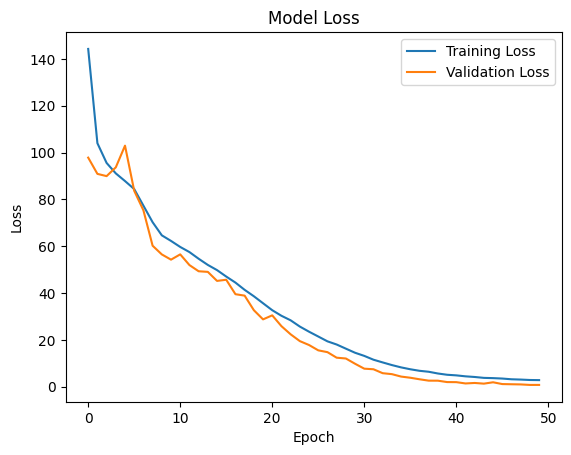

In [28]:

from matplotlib import pyplot as plt
# Plot training & validation loss values
plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [29]:
# class AccuracyMetrics(tf.keras.callbacks.Callback):
#     def __init__(self, dataset) -> None:
#         self.dataset = dataset.as_numpy_iterator()
#         self.predictions = []
#         self.ground_truth = []
#         self.accuracies = []  # Store accuracies at each epoch

#     def on_epoch_end(self, epoch, logs=None) -> None:
#         data = self.dataset.next()
#         yhat = self.model.predict(data[0])
#         decoded = tf.keras.backend.ctc_decode(yhat, [75, 75], greedy=False)[0][0].numpy()
#         self.predictions.extend(decoded)
#         self.ground_truth.extend(data[1])

# # ... (your previous code)

# accuracy_metrics = AccuracyMetrics(test)  # Create an instance of AccuracyMetrics

# model.fit(train, validation_data=test, epochs=50, callbacks=[checkpoint_callback, schedule_callback, accuracy_metrics])

# # After training, compute accuracy or any other metric using predictions and ground truth
# predictions = accuracy_metrics.predictions
# ground_truth = accuracy_metrics.ground_truth

# # Compute accuracy (or any other suitable metric) here
# # For example, using sequence_accuracy from Levenshtein distance:
# from nltk.metrics.distance import edit_distance

# def compute_accuracy(preds, truths):
#     acc = sum(edit_distance(pred, truth) for pred, truth in zip(preds, truths)) / len(preds)
#     return 1 - acc

# accuracy = compute_accuracy(predictions, ground_truth)
# print("Accuracy:", accuracy)

In [30]:
# After training, plot the accuracy over epochs
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(accuracy_metrics.accuracies, label='Accuracy')
# plt.xlabel('Epoch')
# plt.legend()
# plt.show()

In [31]:
# Save the model in the native Keras format
from tensorflow.keras.models import save_model
save_model(model, 'models/my_model.keras')


الحمد الله 